In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import statsmodels.api as sm

import scipy.stats as stats
import cartopy.crs as ccrs
import pylab
import tables


sns.set_theme(style="white")
sns.set_style("white")
random.seed(10)

## Load single member

In [2]:
tracks1 = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.h5')
# tracks1.head()
# tracks1.date.values
tracks1.columns

Index(['Dp', 'DpDt', 'DsqP', 'Dx', 'Dy', 'Ege', 'Ely', 'Emg', 'Erg', 'Esp',
       'area', 'centers', 'depth', 'id', 'lat', 'long', 'p_cent', 'p_edge',
       'pid', 'ptid', 'radius', 'time', 'type', 'u', 'uv', 'v', 'x', 'y',
       'sid', 'year', 'mon', 'uid', 'date', 'dDist'],
      dtype='object')

In [3]:
pd.unique(tracks1.uid)

array(['202202000', '202202001', '202202002', '202202003', '202202004',
       '202202005', '202202006', '202202007', '202202008', '202202009',
       '202202010', '202202011', '202202012', '202202013', '202202014',
       '202202015', '202202016', '202202017', '202202018', '202202019',
       '202202020', '202202021', '202202022', '202202023', '202202024',
       '202202025', '202202026', '202202027', '202202028', '202202029',
       '202202030', '202202031', '202202032'], dtype=object)

The following track could be the Eunice track in this member, uid = '202202022', also uid = '202202007'. It is longer than one day, gets sufficiently strong and is created in the area that we would expect.

In [4]:
tracks1[tracks1.uid=='202202007'][['uid', 'date', 'lat', 'long', 'p_cent']] 

,uid,date,lat,long,p_cent
0,202202007,2022-02-13 00:00:00,48.230246,-16.744418,100086.349352
1,202202007,2022-02-13 06:00:00,48.659863,-11.994958,99237.849209
2,202202007,2022-02-13 12:00:00,49.165703,-8.220976,98664.928501
3,202202007,2022-02-13 18:00:00,49.737891,-4.074016,98232.188081
4,202202007,2022-02-14 00:00:00,51.514572,0.170017,98082.598661
5,202202007,2022-02-14 06:00:00,52.886808,2.994281,98005.901722
6,202202007,2022-02-14 12:00:00,53.683352,5.943138,98411.008947
7,202202007,2022-02-14 18:00:00,56.843309,10.462879,98702.431375
8,202202007,2022-02-15 00:00:00,57.472978,13.114545,98803.804994
9,202202007,2022-02-15 06:00:00,57.982583,17.535762,98832.707092


In [5]:
print('Minimum pressure = ', min(tracks1[tracks1.uid=='202202022'].p_cent))
print('Genesis latitude = ', tracks1[tracks1.uid=='202202022'].lat.values[0])
print('Genesis longitude = ', tracks1[tracks1.uid=='202202022'].long.values[0])

Minimum pressure =  96736.45858827776
Genesis latitude =  59.728563217893175
Genesis longitude =  28.387919663540384


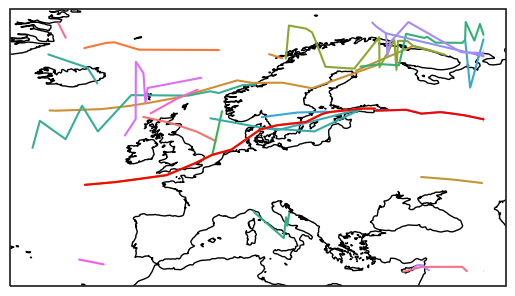

In [6]:
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

sns.lineplot(data=tracks1,x='long',y='lat',hue='uid',legend=False)
sns.lineplot(data=tracks1[tracks1.uid == '202202007'],x='long',y='lat',color='red',legend=False)
sns.lineplot(data=tracks1[tracks1.uid == '202202022'],x='long',y='lat',color='red',legend=False)
ax.coastlines()

In [7]:
early_date = pd.Timestamp(2022,2,16, 0)
late_date =  pd.Timestamp(2022,2,18, 18)

# Filter uid
eunice_ids = [] # fill with those ids that could be Eunice
for id_ in pd.unique(tracks1.uid): 
    # print(id_)
    data_for_id = tracks1[tracks1.uid == id_]
    # print('Genesis data: ', data_for_id.date[0], data_for_id.long[0], data_for_id.lat[0])
    min_pres = min(data_for_id.p_cent) < 99000  # in Pa not hPa 
    gen_lat = (data_for_id.lat[0] > 40) & (data_for_id.lat[0] < 65)
    gen_long = (data_for_id.long [0] > -45) & (data_for_id.long[0] < 0)
    gen_time = ((data_for_id.date[0] >=  early_date) & (data_for_id.date[0] < late_date))

    # print(min_pres, gen_lat, gen_long, gen_time)
    
    if min_pres & gen_lat & gen_long & gen_time:
        eunice_ids.append(id_)

In [8]:
eunice_ids

[]

## Filter tracks in all members

In [10]:
## Load all members, ensemble i.e current climate
dates = ['10', '14', '16']
cfpf = ['cf', 'pf']

# Initialise empty data frame
tracks_curr = pd.DataFrame({'uid' : [],
                              'date' : [], 
                              'lat' : [], 
                              'long' : [], 
                              'p_cent' : []})
members = np.arange(1,51,1)

for date in dates:
    for c in cfpf:
        if c == 'pf': 
            for member in members:
                tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/'+c+'/1_2022-02-'+date+'_mem'+str(member)+'.h5')
                tracks_curr = pd.merge(tracks_curr, 
                                       tracks[['uid', 'date', 'lat', 'long', 'p_cent']], 
                                       how = 'outer')
                tracks_curr.uid = tracks_curr.uid.values+'_init'+str(date)+'_mem'+str(member)
        else: 
            tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/'+c+'/1_2022-02-'+date+'.h5')
            tracks_curr = pd.merge(tracks_curr, 
                                   tracks[['uid', 'date', 'lat', 'long', 'p_cent']], 
                                   how = 'outer')
            tracks_curr.uid = tracks_curr.uid.values+'_init'+str(date)+'_mem'+str(member)

In [15]:
tracks_curr.uid = tracks_curr.uid.values+'_init'+str(date)+'_mem'+str(member)

In [16]:
tracks_curr.uid 

0        202202000_16_50_date16_mem50_init16_mem50
1        202202000_16_50_date16_mem50_init16_mem50
2        202202000_16_50_date16_mem50_init16_mem50
3        202202000_16_50_date16_mem50_init16_mem50
4        202202000_16_50_date16_mem50_init16_mem50
                           ...                    
20999    202202008_16_50_date16_mem50_init16_mem50
21000    202202009_16_50_date16_mem50_init16_mem50
21001    202202009_16_50_date16_mem50_init16_mem50
21002    202202010_16_50_date16_mem50_init16_mem50
21003    202202010_16_50_date16_mem50_init16_mem50
Name: uid, Length: 21004, dtype: object